In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

F:\Python\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
F:\Python\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
F:\Python\Anaconda\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
## loading data using Pandas

tweets = pandas.read_csv('C:\\Users\\Raghavendra Reddy\\Desktop\\Text analytics\\Assignment 3\\train_tweets.csv',encoding="utf8")
print(tweets.head())

   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation


In [3]:
## To get pivot of dataset

tweets.groupby('label').describe()

id                                                               \
         count          mean          std   min      25%      50%       75%   
label                                                                         
0      29720.0  15974.454441  9223.783469   1.0  7981.75  15971.5  23965.25   
1       2242.0  16074.896075  9267.955758  14.0  8075.25  16095.0  24022.00   

                
           max  
label           
0      31962.0  
1      31961.0

In [4]:
## adding extra column to get the length of the text

tweets['length'] = tweets['tweet'].map(lambda text: len(text))
print (tweets.head())

   id  label                                              tweet  length
0   1      0   @user when a father is dysfunctional and is s...     102
1   2      0  @user @user thanks for #lyft credit i can't us...     122
2   3      0                                bihday your majesty      21
3   4      0  #model   i love u take with u all the time in ...      86
4   5      0             factsguide: society now    #motivation      39


count    31962.000000
mean        84.739628
std         29.455749
min         11.000000
25%         63.000000
50%         88.000000
75%        108.000000
max        274.000000
Name: length, dtype: float64

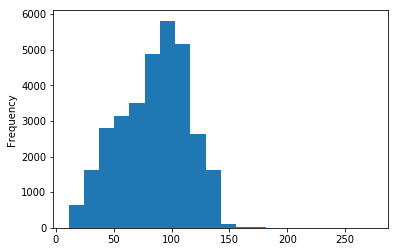

In [5]:
## plotting

tweets.length.plot(bins=20, kind='hist')

tweets.length.describe()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F6977625C0>,
      dtype=object)

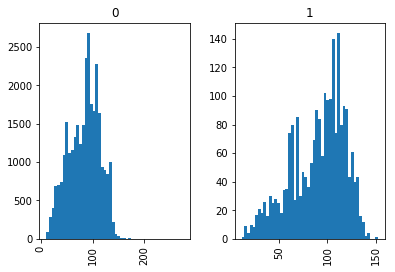

In [6]:
## checking out the difference between ham and spam

tweets.hist(column='length', by='label', bins=50)

In [7]:
## Data Preprocessing

## we'll use the bag-of-words approach, where each unique word in a text will be represented by one number.

## splitting it into tokens
def split_into_tokens(tweet):
    return TextBlob(tweet).words

In [8]:
## original text
tweets.tweet.head()

0     @user when a father is dysfunctional and is s...
1    @user @user thanks for #lyft credit i can't us...
2                                  bihday your majesty
3    #model   i love u take with u all the time in ...
4               factsguide: society now    #motivation
Name: tweet, dtype: object

In [9]:
## now text after tokenized
tweets.tweet.head().apply(split_into_tokens)

0    [user, when, a, father, is, dysfunctional, and...
1    [user, user, thanks, for, lyft, credit, i, ca,...
2                              [bihday, your, majesty]
3    [model, i, love, u, take, with, u, all, the, t...
4               [factsguide, society, now, motivation]
Name: tweet, dtype: object

In [10]:
## Part of speech tag (POS)

TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

[('Hello', 'NNP'),
 ('world', 'NN'),
 ('how', 'WRB'),
 ('is', 'VBZ'),
 ('it', 'PRP'),
 ('going', 'VBG')]

In [15]:
## lemmatizing --- normalize words into their base form

def split_into_lemmas(tweet):
    words = TextBlob(tweet).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

tweets.tweet.head().apply(split_into_lemmas)

0    [user, when, a, father, is, dysfunctional, and...
1    [user, user, thanks, for, lyft, credit, i, ca,...
2                              [bihday, your, majesty]
3    [model, i, love, u, take, with, u, all, the, t...
4               [factsguide, society, now, motivation]
Name: tweet, dtype: object

In [18]:
## Data to Vectors

# Now we'll convert each message, represented as a list of tokens (lemmas) above, 
# into a vector that machine learning models can understand.

# Doing that requires essentially three steps, in the bag-of-words model:

# 1. counting how many times does a word occur in each message (term frequency)
# 2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
# 3. normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

# Each vector has as many dimensions as there are unique words in the SMS corpus:

bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(tweets['tweet'])
len(bow_transformer.vocabulary_)

44434

In [20]:
# Here we used `scikit-learn` (`sklearn`), a powerful Python library for teaching machine learning. 
# It contains a multitude of various methods and options.

# Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

## Feature Engineering

tweet4 = tweets['tweet'][3]
print (tweet4)

#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  


In [22]:
bow4 = bow_transformer.transform([tweet4])
print(bow4)
print(bow4.shape)

  (0, 2528)	1
  (0, 17941)	1
  (0, 18435)	1
  (0, 21994)	1
  (0, 23901)	1
  (0, 35230)	1
  (0, 35824)	1
  (0, 36371)	1
  (0, 37452)	2
  (0, 37924)	1
  (0, 39706)	1
  (0, 43048)	1
  (0, 43821)	1
(1, 44434)


In [25]:
tweets_bow = bow_transformer.transform(tweets['tweet'])
print ('sparse matrix shape:', tweets_bow.shape)
print ('number of non-zeros:', tweets_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * tweets_bow.nnz / (tweets_bow.shape[0] * tweets_bow.shape[1])))

sparse matrix shape: (31962, 44434)
number of non-zeros: 394686
sparsity: 0.03%


In [27]:

# And finally, after the counting, the term weighting and normalization 
# can be done with [TF-IDF] using scikit-learn's `TfidfTransformer`:

tfidf_transformer = TfidfTransformer().fit(tweets_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print (tfidf4)

  (0, 43821)	0.32253482077659806
  (0, 43048)	0.322357957928932
  (0, 39706)	0.20604135297071888
  (0, 37924)	0.32253482077659806
  (0, 37452)	0.4936052481226372
  (0, 36371)	0.2472818440284068
  (0, 35824)	0.13690718632343743
  (0, 35230)	0.2817169177205784
  (0, 23901)	0.31353215497203735
  (0, 21994)	0.20203689796455812
  (0, 18435)	0.17467955994093995
  (0, 17941)	0.15517744307756376
  (0, 2528)	0.22126483679070025


In [29]:
# To check what is the IDF (inverse document frequency) of the word `"u"`? Of word `"university"`?

print (tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print (tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

4.273958624218329
7.46031125738097


In [31]:
# To transform the entire bag-of-words corpus into TF-IDF corpus at once:

tweets_tfidf = tfidf_transformer.transform(tweets_bow)
print (tweets_tfidf.shape)

(31962, 44434)


In [32]:
## Training a model
# We'll be using scikit-learn here, choosing the [Naive Bayes] 
# classifier to start with:

%time spam_detector = MultinomialNB().fit(tweets_tfidf, tweets['label'])

Wall time: 141 ms


In [34]:
# Let's try classifying our single random message:

print ('predicted:', spam_detector.predict(tfidf4)[0])
print ('expected:', tweets.label[3])

predicted: 0
expected: 0


In [35]:
all_predictions = spam_detector.predict(tweets_tfidf)
print (all_predictions)

[0 0 0 ... 0 1 0]


accuracy 0.9405544083599274
confusion matrix
 [[29720     0]
 [ 1900   342]]
(row=expected, col=predicted)


Text(0.5,0,'predicted label')

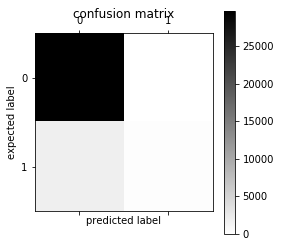

In [36]:
## Calculating accuracy and confusion matrix on Training data which will definitely give good accuracy

print ('accuracy', accuracy_score(tweets['label'], all_predictions))
print ('confusion matrix\n', confusion_matrix(tweets['label'], all_predictions))
print ('(row=expected, col=predicted)')

plt.matshow(confusion_matrix(tweets['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [38]:
print (classification_report(tweets['label'], all_predictions))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97     29720
          1       1.00      0.15      0.26      2242

avg / total       0.94      0.94      0.92     31962



In [40]:
## splitting the data into training and testing

msg_train, msg_test, label_train, label_test = \
    train_test_split(tweets['tweet'], tweets['label'], test_size=0.2)

print (len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

25569 6393 31962


In [41]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [ ]:

## Cross Validation

# A common practice is to partition the training set again, into smaller subsets; for example, 5 equally sized subsets. 
# Then we train the model on four parts, and compute accuracy on the last part (called "validation set"). 
# Repeated five times (taking different part for evaluation each time), we get a sense of model "stability". 
# If the model gives wildly different scores for different subsets, it's a sign something is wrong (bad data, or bad model variance). 
# Go back, analyze errors, re-check input data for garbage, re-check data cleaning.

scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print (scores)